In [4]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Comment here to add in for either mac or linux computer
if os.environ['SHELL'] == '/bin/bash':   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
else:    # For mac laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [6]:
sess_dir = '/data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/'
sess_name = f"{sess_dir.split('/')[-3]}_{sess_dir.split('/')[-2].split('_')[-1]}"
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/Han_recall1.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [7]:
print(sess.eegfile)

duration: 3594.69 seconds 
duration: 1.00 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [8]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)
art_epochs

Existing artifact epochs file loaded


11 epochs
Snippet: 
       start      stop label
0  381.0232  381.2760      
1  561.4368  561.6952      
2  661.1000  661.3360      
3  734.1248  734.3784      
4  942.7544  942.9848      

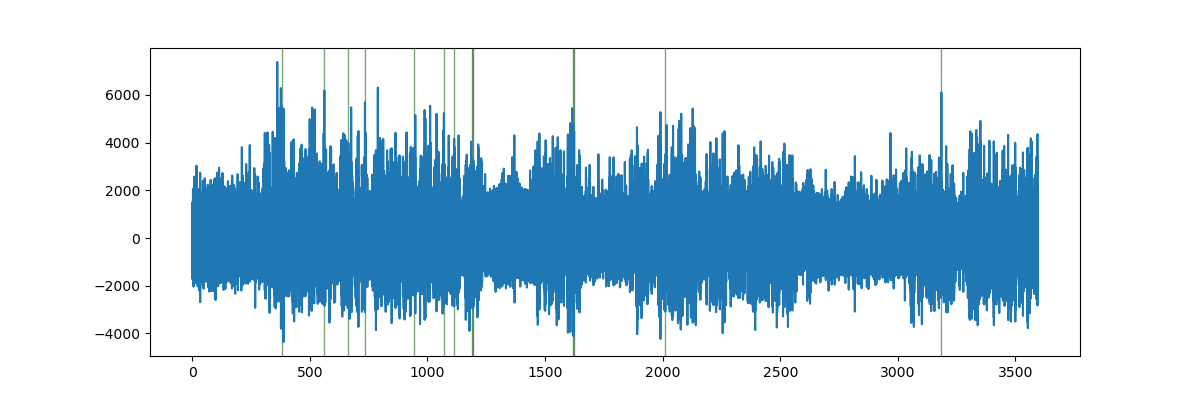

In [9]:
%matplotlib widget
_, ax = plt.subplots(figsize=(12, 4))
chan_plot = 6
ax.plot(signal.time, signal.traces[chan_plot])

for start, stop in zip(art_epochs.starts, art_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/Han_recall1.probegroup.npy saved


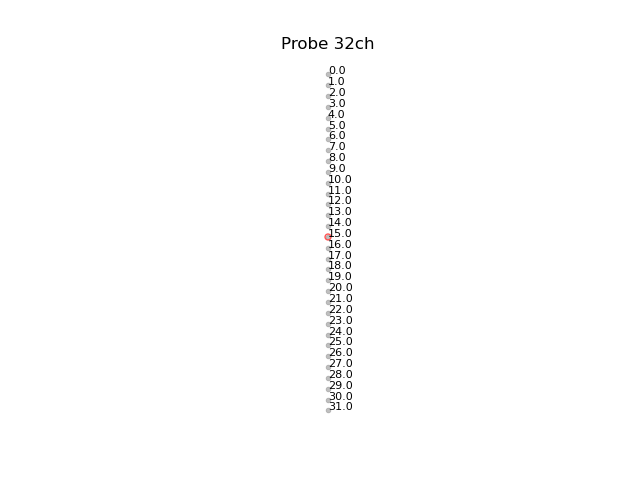

In [10]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [11]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 6

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [6]
993 epochs remaining with durations within (0.25,20)


## Detect SWR Epochs

In [12]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 6
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [6]
1015 epochs remaining with durations within (0.05,0.45)


# Wavelet Analysis

### Start with Theta

In [13]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

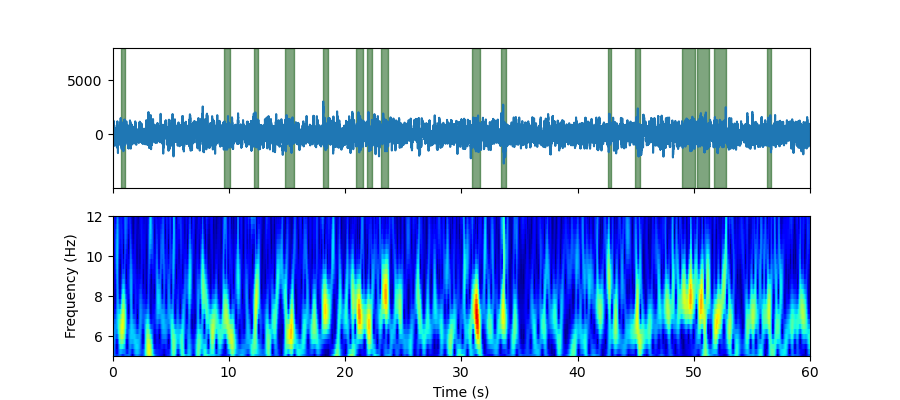

In [14]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [992] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

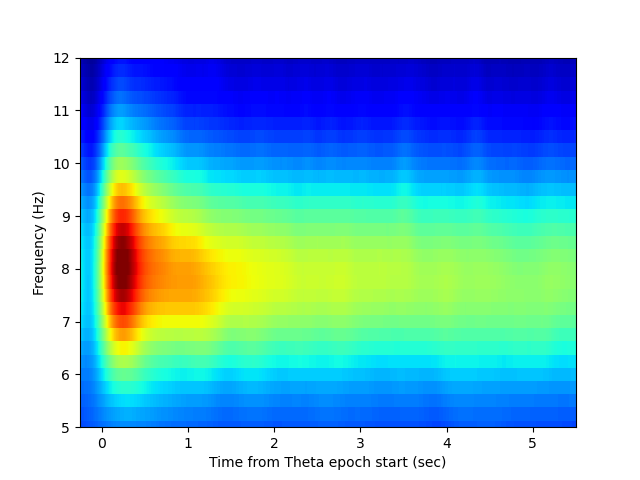

In [15]:
theta_buffer_sec = (0.25, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [16]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

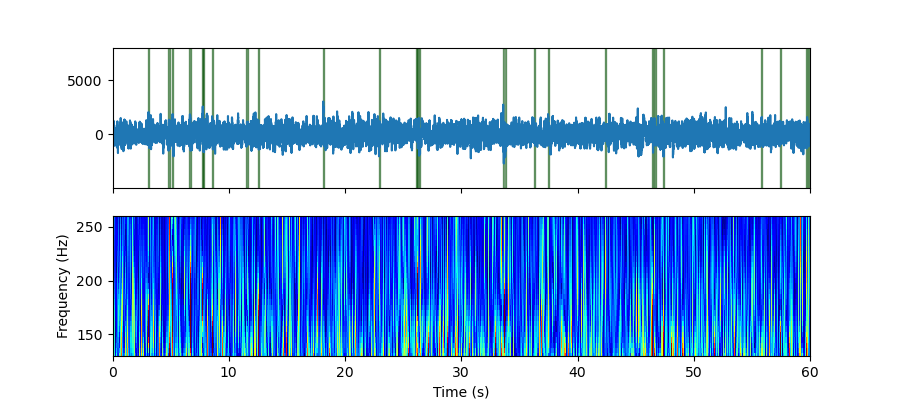

In [17]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

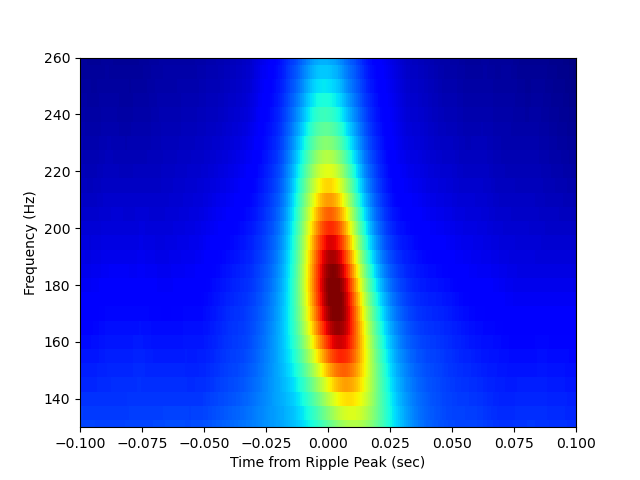

In [18]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

,channel_states,timestamps,datetimes,event_name
616,2,3550347,2022-08-04 12:25:54.344900000,
1245,2,5430969,2022-08-04 12:26:57.032300000,
1966,2,7586021,2022-08-04 12:28:08.867366667,
2727,2,9862870,2022-08-04 12:29:24.762333333,
3427,2,11956605,2022-08-04 12:30:34.553500000,


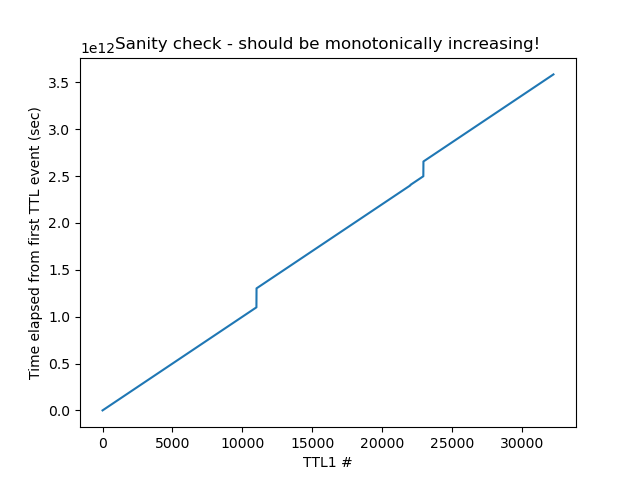

In [19]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'] == 2].head(5)

In [28]:
import tracefc.io.traceio as traceio
cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs_starts.shape[0]} CS+ events detected')
print(cs_starts.head(6))

csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS-", return_df=True)
print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
5    61.717939  CS1_start 2022-08-04 12:25:54.919410900
7   124.405071  CS2_start 2022-08-04 12:26:57.606542782
9   196.239824  CS3_start 2022-08-04 12:28:09.441295580
11  272.134283  CS4_start 2022-08-04 12:29:25.335755066
13  341.925044  CS5_start 2022-08-04 12:30:35.126516298
15  409.700099  CS6_start 2022-08-04 12:31:42.901571230
12 CS- events detected
      Time (s)      Event                     Timestamp
5    61.717573  CS1_start 2022-08-04 12:47:37.022604166
7   142.654433  CS2_start 2022-08-04 12:48:57.959463774
9   214.490291  CS3_start 2022-08-04 12:50:09.795321880
11  290.384380  CS4_start 2022-08-04 12:51:25.689410625
13  366.248231  CS5_start 2022-08-04 12:52:41.553262173
15  433.009095  CS6_start 2022-08-04 12:53:48.314126192


In [21]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-08-04 12:23:56.581623-04:00
start time = 2022-08-04 12:45:27.837675-04:00
start time = 2022-08-04 13:07:02.327536-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-08-04 12:23:56.581623-04:00,start,0,0.000000,0,0.0000
1,0,2022-08-04 12:44:28.999723-04:00,stop,36972543,1232.418100,1540522,1232.4176
2,1,2022-08-04 12:45:27.837675-04:00,start,36972544,1232.418133,1540523,1232.4184
3,1,2022-08-04 13:06:38.655775-04:00,stop,75097087,2503.236233,3129045,2503.2360
4,2,2022-08-04 13:07:02.327536-04:00,start,75097088,2503.236267,3129046,2503.2368
5,2,2022-08-04 13:25:13.783502667-04:00,stop,107840767,3594.692233,4493365,3594.6920


In [30]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.6, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

start time lag: mean = -0.5718395172000001, std = 0.0017393610604866253
start time lag: mean = -0.8315851157500003, std = 0.0012104381031523726


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

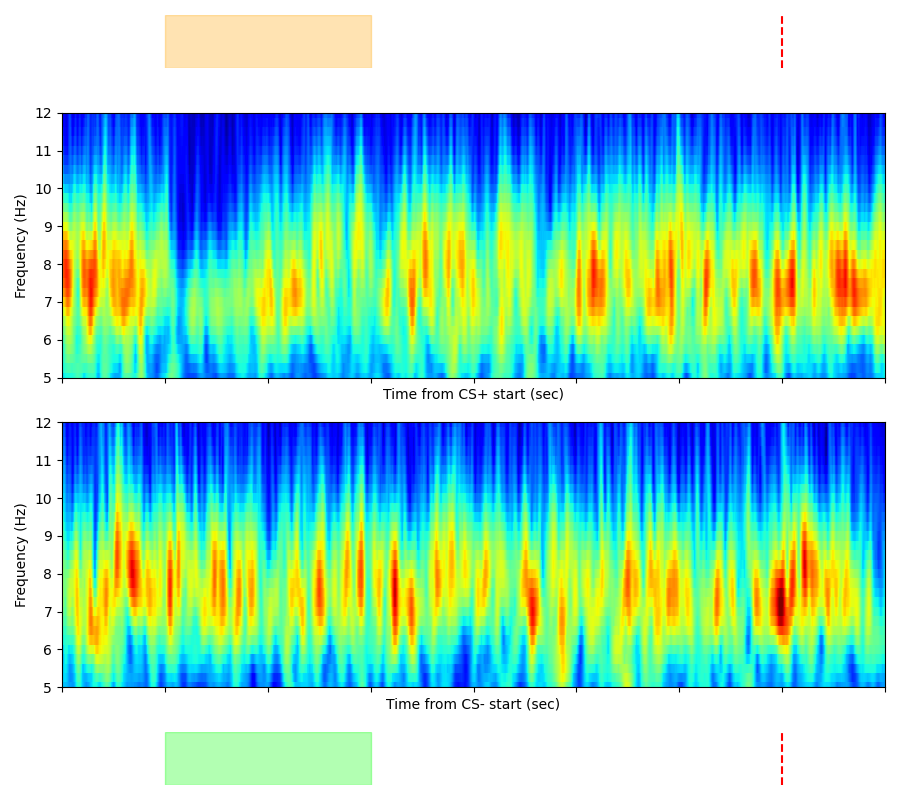

In [38]:
# Plot mean wavelet spectrogram at CS+ onset
cs_buffer = (5, 35)

### NRK todo: add in recording_events_to_combined_time function here! Or is is necessary?
wv_theta_cs_mean = wv_theta.get_pe_mean_spec(cs_oe_start_df['timestamps'].values/30000, buffer_sec=cs_buffer)

_, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 5, 1], sharex=True, layout='tight')

plot_spectrogram(wv_theta_cs_mean, time_lims=np.multiply(cs_buffer, (-1, 1)), freq_lims=theta_freq_lims, ax=ax[1])
ax[1].set_xlabel('Time from CS+ start (sec)')

wv_theta_csn_mean = wv_theta.get_pe_mean_spec(csn_oe_start_df['timestamps'].values/30000, buffer_sec=cs_buffer)
plot_spectrogram(wv_theta_csn_mean, time_lims=np.multiply(cs_buffer, (-1, 1)), freq_lims=theta_freq_lims, ax=ax[2])
ax[2].set_xlabel('Time from CS- start (sec)')

# Add color keys to plots above/below
ax[0].axvspan(0, 10, color=[1, 0.647, 0, 0.3])
ax[3].axvspan(0, 10, color=[0, 1, 0, 0.3])
[a.axvline(30, color='r', linestyle='--') for a in (ax[0], ax[3])];
[a.axis('off') for a in (ax[0], ax[3])];

## Save notebook to working directory

In [39]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/Han_recall1_Spectral_Analysis.ipynb
